In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json, time, requests, os
import matplotlib.pyplot as plt

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

Tests for running models for the city of Chicago

# Load and Split Data

In [3]:
# load
merged_df = pd.read_pickle('merged_daily.pickle')

# remove objects and fare data
merged_df = merged_df[merged_df.columns[merged_df.dtypes != object]]
merged_df = merged_df.loc[:, 'rides':]

# make sure there aren't any missing hours
index = merged_df.index
dtrange = pd.DataFrame(index=pd.date_range(index[0], index[-1], freq='h'))
merged_df = pd.merge(dtrange, merged_df, how='left',
                     left_index=True, right_index=True).fillna(0)

# create split for last three days in dataset
split = '2019-07-09'

# train/test split
train = merged_df['rides'][merged_df.index < split]
test = merged_df['rides'][(merged_df.index >= split)]

# train
train_exog = merged_df[merged_df.index < split].drop(columns=['rides'])
test_exog = merged_df[merged_df.index >= split].drop(columns=['rides'])

# remove unnecessary variables from memory
# del merged_df, dtrange, index, split

# make sure that the indexes are different
[x for x in train.index if x in test.index]

[]

In [26]:
## to fit the area modeling
# df = pd.read_pickle('community_hour.pickle')

# split = '2019-10-03'

# train = df[df['date_time'] < split]
# test = df[df['date_time'] >= split]

# Table of Models
### 1. [SARIMA](#SARIMA)
### 2. [Auto_ARIMA](#auto_arima)
### 3. [Holt-Winters](#Holt-Winters)

<a id='SARIMA'></a>
# SARIMA

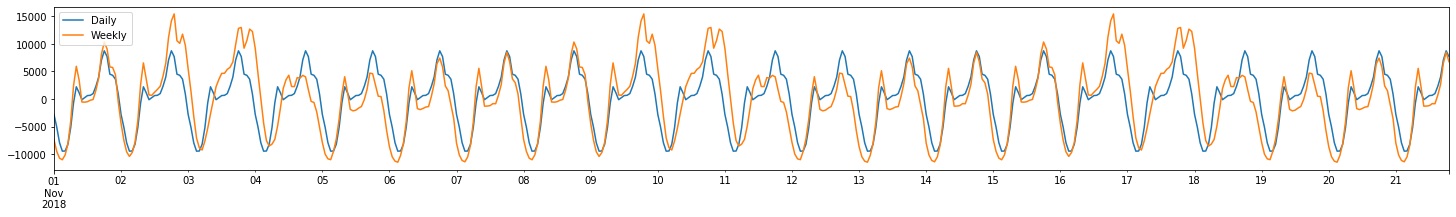

In [276]:
# 24 hour seasonality
decomposition = seasonal_decompose(train[:500], freq=24)  
decomposition.seasonal.plot(figsize=(25,3), label='Daily')

# Weekly seasonality
decomposition = seasonal_decompose(train[:500], freq=168)  
decomposition.seasonal.plot(figsize=(25,3), label='Weekly')
plt.legend(loc='upper left');

In [136]:
train
daily_diff = train - train.shift(24)
weekly_diff = train - train.shift(168)
first_diff = train - train.shift(1)
first_daily_diff = first_diff - first_diff.shift(24)
first_weekly_diff = first_diff - first_diff.shift(168)

to_test = [train, daily_diff, weekly_diff,
 first_diff, first_daily_diff, first_weekly_diff]

In [137]:
def adfuller_plot(timeseries_list, start=0, end = -1):
    '''
    input list of differenced timeseries
    run dicky-fuller tests on input timeseries
    returning plots and testing statistics
    '''
    
    # helper object for naming differencing
    def namestr(obj, name = globals()):
        return [x for x in name if name[x] is obj][0]
    
    test_names = [namestr(x) for x in timeseries_list]
    
    for name, series in zip(test_names, timeseries_list):

        # creating the avg and std
        avg = series.rolling(24).mean()
        std = series.rolling(24).std()

        # plot the timeseries
        plt.figure(figsize=(20,5))
        series[start:end].plot(label='timeseries')
        avg[start:end].plot(label='moving average')
        std[start:end].plot(label='standard deviation')
        plt.title(name, fontsize=16)
        plt.legend()
        plt.show()

        dicky = adfuller(series.dropna())[:-1]
        labels = ['test statistic','p-value','# lags used','number of observations','critical values']

        results = dict(zip(labels, dicky[:5]))
        for key in results.keys():
            print(f'{key}: {results[key]}')
        
        print('\n------------------')

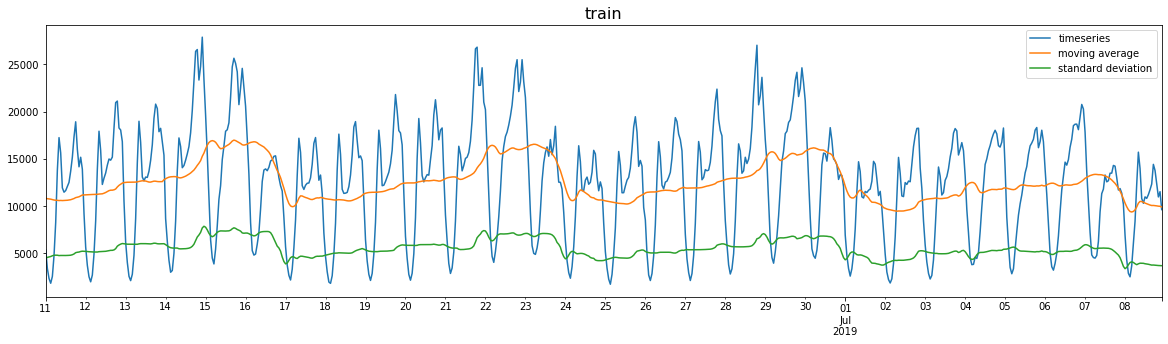

test statistic: -9.465353183507903
p-value: 4.2446307395022506e-16
# lags used: 31
number of observations: 5967
critical values: {'1%': -3.4314463826663104, '5%': -2.8620244998649, '10%': -2.567027896892211}

------------------


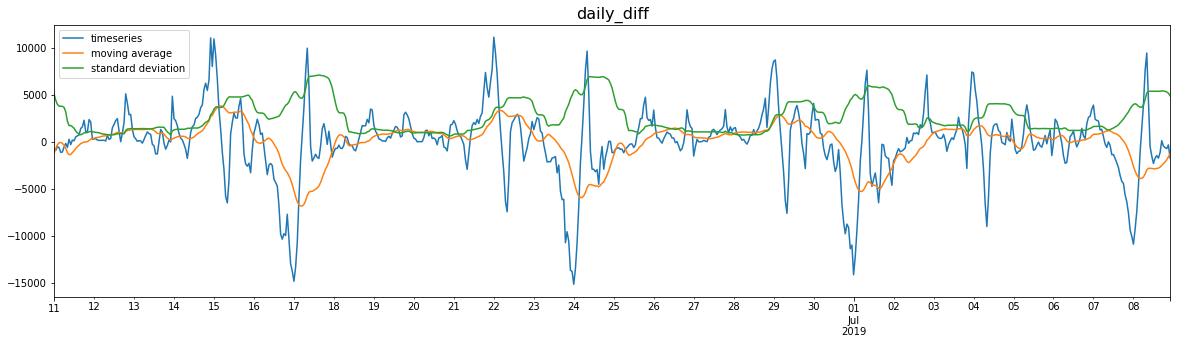

test statistic: -11.818457102702386
p-value: 8.52645852374509e-22
# lags used: 34
number of observations: 5939
critical values: {'1%': -3.431451553907018, '5%': -2.8620267846522682, '10%': -2.5670291131461944}

------------------


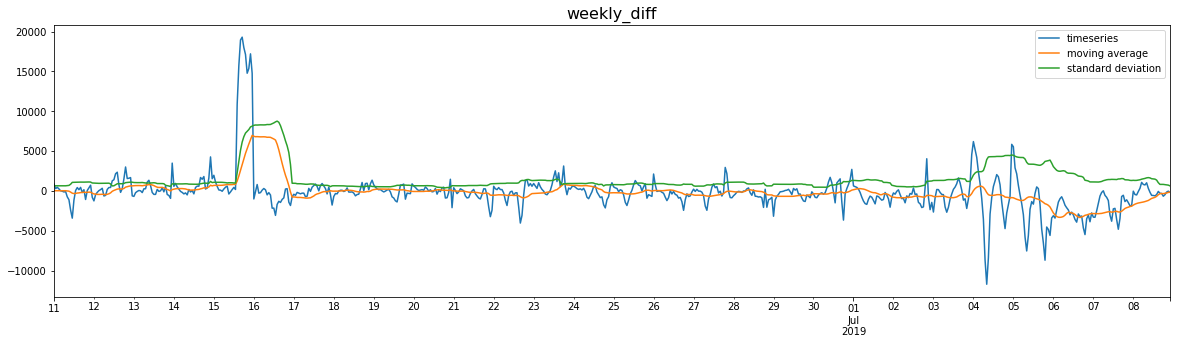

test statistic: -8.142598536956713
p-value: 1.0186612090019858e-12
# lags used: 29
number of observations: 5800
critical values: {'1%': -3.4314779649136544, '5%': -2.8620384536534917, '10%': -2.5670353248810938}

------------------


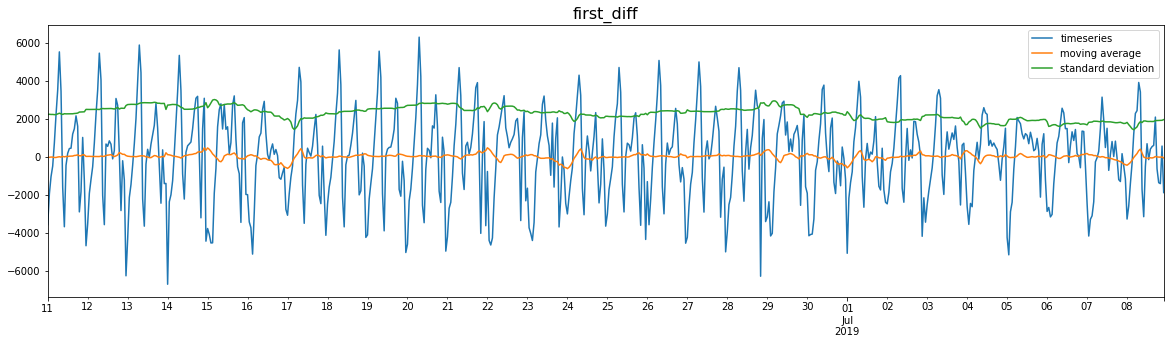

test statistic: -18.100315575587242
p-value: 2.554761918263918e-30
# lags used: 34
number of observations: 5962
critical values: {'1%': -3.4314473025382157, '5%': -2.862024906288296, '10%': -2.5670281132423045}

------------------


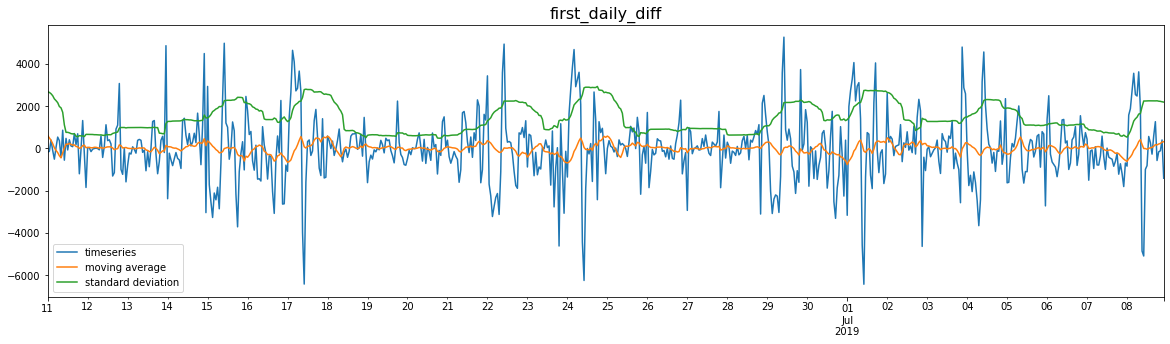

test statistic: -19.09687670336328
p-value: 0.0
# lags used: 34
number of observations: 5936
critical values: {'1%': -3.431452110863291, '5%': -2.8620270307296614, '10%': -2.567029244139873}

------------------


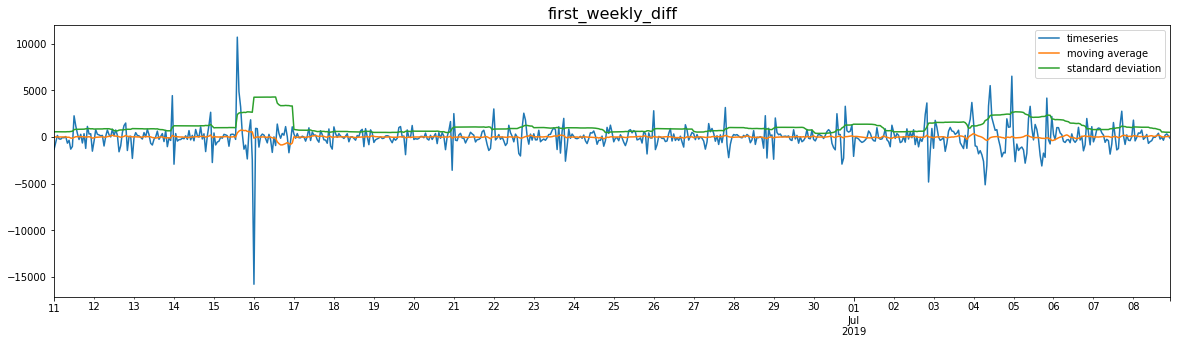

test statistic: -20.682915306238687
p-value: 0.0
# lags used: 31
number of observations: 5795
critical values: {'1%': -3.431478938567795, '5%': -2.8620388838347126, '10%': -2.567035553878898}

------------------


In [138]:
adfuller_plot(to_test, start=-24*7*4)

###### First Differencing seems to have the most stationarity, with the lowest p-value

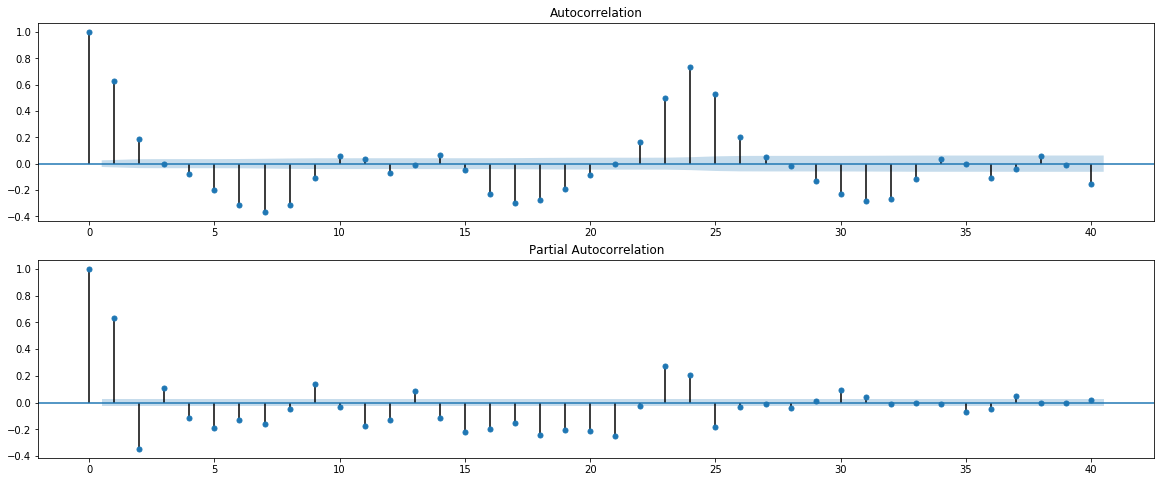

In [139]:
def plot_arma(timeseries, num_lags=40):
    
    fig = plt.figure(figsize=(20, 8))

    ax1 = fig.add_subplot(2,1,1)
    fig = plot_acf(timeseries, lags=num_lags, ax=ax1)
    
    ax2 = fig.add_subplot(2,1,2)
    fig = plot_pacf(timeseries, lags=num_lags, ax=ax2)
    
plot_arma(first_diff)

In [147]:
def fit_sarima(timeseries, freq=None, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0),
               trend=None, measurement_error=False, time_varying_regression=False,
               mle_regression=True, simple_differencing=False, enforce_stationarity=True,
               enforce_invertibility=True, hamilton_representation=False, concentrate_scale=False):
    
    if freq:
        timeseries = timeseries.asfreq(freq)
    else:
        timeseries = pd.DataFrame(timeseries.dropna())
        
    if exog:
        exog = exog.fillna(0)
    
    mod = SARIMAX(timeseries, freq=freq, exog=exog, order=order, seasonal_order=seasonal_order, trend=trend,
                  measurement_error=measurement_error, time_varying_regression=time_varying_regression,
                  mle_regression=mle_regression, simple_differencing=simple_differencing,
                  enforce_stationarity=enforce_stationarity, enforce_invertibility=enforce_invertibility,
                  hamilton_representation=hamilton_representation, concentrate_scale=concentrate_scale)
    
    fit_mod = mod.fit()
    
    print(fit_mod.summary())
    
    return fit_mod

In [141]:
%time mod = fit_sarima(train, freq='h', order=(1, 1, 2),seasonal_order=(1, 1, 2, 24))

                                 Statespace Model Results                                 
Dep. Variable:                              rides   No. Observations:                 6000
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 24)   Log Likelihood              -51184.502
Date:                            Sun, 22 Mar 2020   AIC                         102383.003
Time:                                    18:34:41   BIC                         102429.871
Sample:                                11-01-2018   HQIC                        102399.282
                                     - 07-08-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8593      0.005    171.593      0.000       0.849       0.869
ma.L1         -0.4730      8.835   

In [1163]:
def plot_predictions(model, train_data, test_data, start=-200, end=-1, shift=0, title=''):
    
    train_data = train_data[start:end]
    train_data.plot(figsize=(20,6), label='train data')
        
    train_pred = mod.predict(start=start, end=end)
    train_pred.plot(label='train predictions')
    
    test_data.plot(label='test data')
    mod.forecast(len(test_data)).plot(label='test predictions')
    plt.legend()
    plt.title(title)
    
    col = ['y_real', 'y_hat']
    
    df = pd.DataFrame(zip(train_data, train_pred), columns=col)
    df['difference'] = abs(df['y_real'] - df['y_hat'])
    
    return df

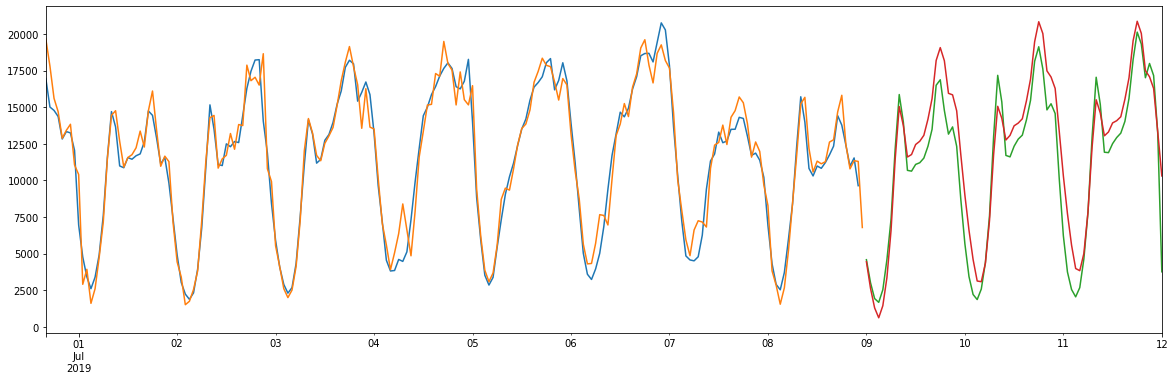

In [149]:
predictions = plot_predictions(mod, train, test, shift=1)

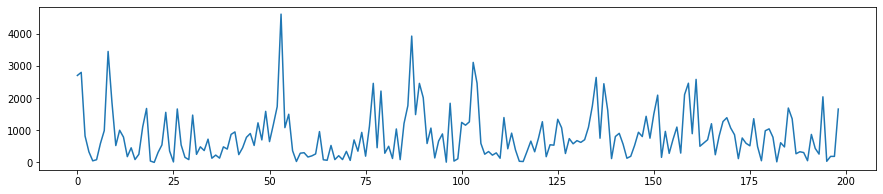

In [150]:
# see if the errors increase over time
predictions['difference'].plot(figsize=(15,3));

In [177]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_real, y_hat):
    return sqrt(mean_squared_error(y_real, y_hat))

In [178]:
rmse(predictions['y_real'], predictions['y_hat'])

1136.390214642357

# Auto_ARIMA
##### See if the pmdarima package produces better results

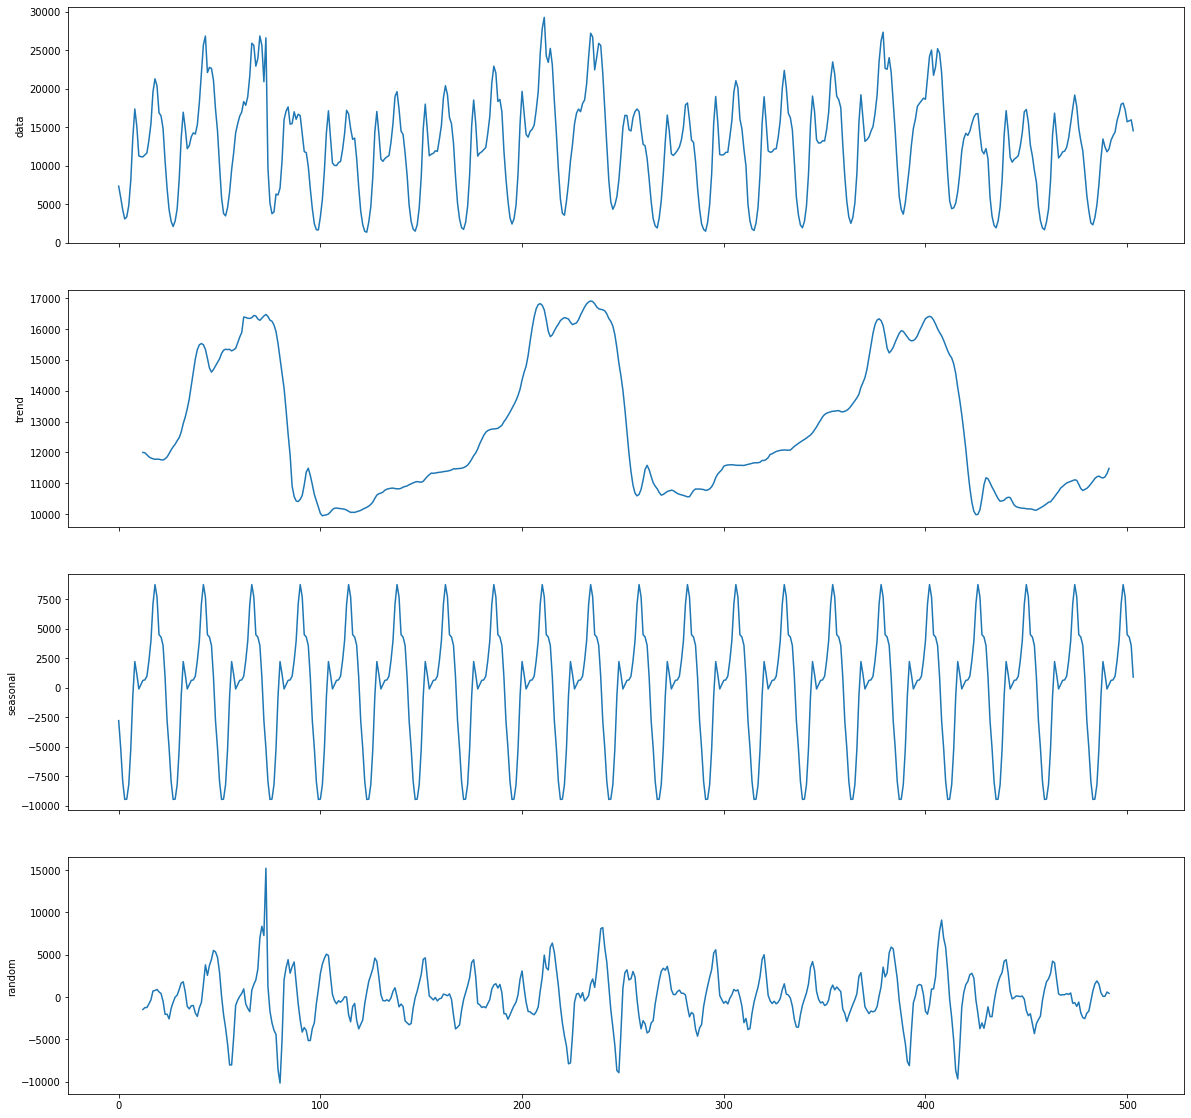

In [16]:
def plot_decomposed(x, m, _type='additive', figure={'figsize': (20, 20)} ):
    
    if type(x) == pd.core.series.Series:
        x = x.values
    
    # create decomposition terms
    decomposed = pm.arima.decompose(x, _type, m)
    
    # plot the decomposition plot
    pm.utils.visualization.decomposed_plot(decomposed, figure_kwargs=figure)

plot_decomposed(train[:24*7*3], 24)

In [24]:
%time mod = pm.auto_arima(y=train.asfreq('h'), exogenous=train_exog, seasonal=True,\
                          m = 24, stepwise=True, suppress_warnings = True, trace=True,\
                          method='nm', maxiter=15, start_p=0, start_q=0, start_P=0, start_Q=0,\
                          max_p=2, max_q=2, max_P=2, max_Q=2, d=1, n_fits=3)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=110639.793, BIC=110753.679, Fit time=0.916 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 24); AIC=114629.692, BIC=114756.976, Fit time=8.597 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 24); AIC=114033.446, BIC=114160.731, Fit time=6.409 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=155554.813, BIC=155662.000, Fit time=0.768 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 24); AIC=112360.525, BIC=112481.110, Fit time=8.603 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 24); AIC=110532.473, BIC=110653.059, Fit time=5.411 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 24); AIC=111656.137, BIC=111783.422, Fit time=6.214 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 2, 24); AIC=110277.457, BIC=110404.742, Fit time=19.581 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 2, 24); AIC=110003.295, BIC=110137.279, Fit time=18.33

In [25]:
print(f'''pmdarima's best:
order = {mod.order}
seasonal_order = {mod.seasonal_order}
aic = {mod.aic()}''')

pmdarima's best:
order = (0, 1, 0)
seasonal_order = (2, 0, 2, 24)
aic = 109996.95937060547


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


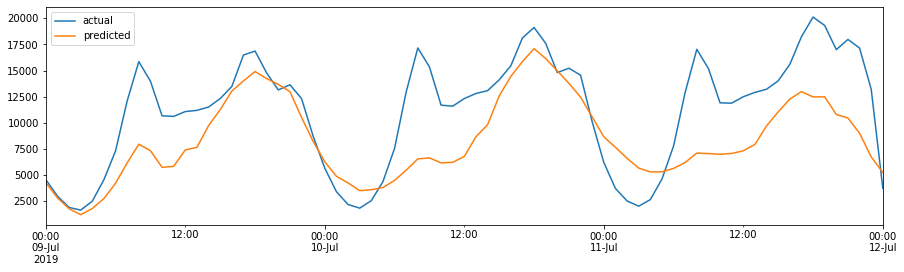

In [26]:
predictions = mod.predict(len(test), test_exog)
predictions = pd.Series(predictions, index=test.index)

test.plot(figsize=(15,3), label='actual')
predictions.plot(label='predicted')
plt.legend();

In [27]:
rmse(test, predictions)

4366.415628371485

<a id='Holt-Winters'></a>
# Holt-Winters

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import holt_modeling as hm
%reload_ext autoreload
%autoreload 2

In [14]:
season_periods = 168

score = hm.fit_hw(train, test, season_periods=season_periods)
print(f'rmse score: {score}')

rmse score: 1135.4884484362562


alpha - randomness smoothing\
beta - for trend smoothing\
gamma - for seasonality smoothing

In [15]:
%time params = hm.get_base_score(train, test, 30, run_test = ['alpha', 'beta', 'gamma'])

CPU times: user 1min, sys: 472 ms, total: 1min 1s
Wall time: 25.3 s


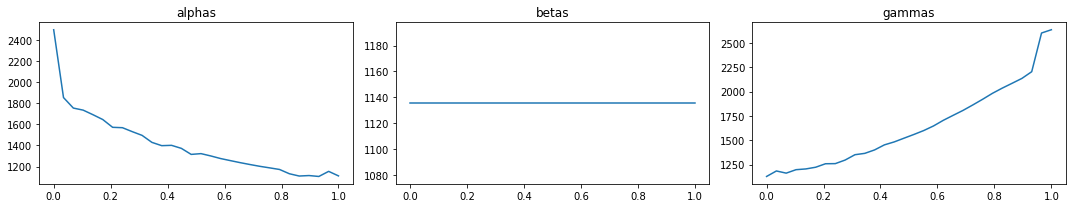

In [16]:
hm.plot_params(params, labels=['alphas', 'betas', 'gammas'])

In [17]:
%time results = hm.parameter_tune(train, test, params,\
                                  num_tests = 20, val_range = .15)

CPU times: user 1min 36s, sys: 627 ms, total: 1min 36s
Wall time: 49.7 s


In [18]:
results = hm.run_final_model(train, test, results)

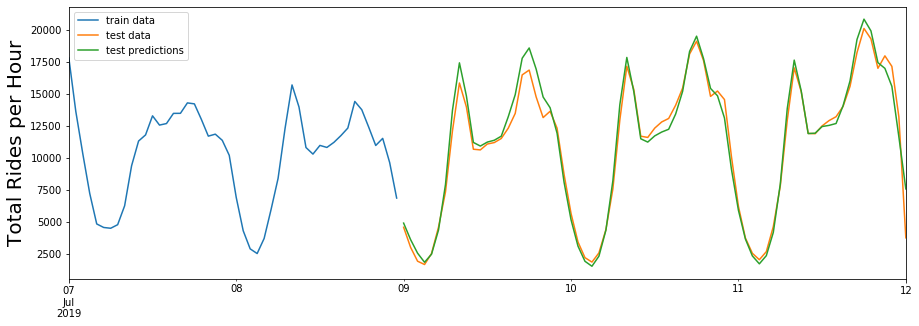

In [19]:
hm.plot_predictions(results, start=-48, validate=False, test=True)